<a href="https://colab.research.google.com/github/afraa-n/XAI-Explainable-Techniques/blob/main/Explainable_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment #5: Explainable Techniques

In this notebook, we'll use LIME (Local Interpretable Model-agnostic Explanations) and SHAP (SHapley Additive exPlanations) to generate local explanations for individual predictions from a pre-trained ResNet34 model on the CIFAR-10 dataset.

## 1. Setup and Imports

We import the libraries we need and we also set random seeds for reproducibility, ensuring the results remain consistent across different runs.

In [1]:
# Import necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)



---



##2. Data Loading and Transformation

Here, we define the necessary data transformations for MNIST:

a. Convert grayscale images to 3 channels to match the ResNet18 input.  
b. Resize the images to 224x224 (the required input size for ResNet).  
c. Normalize the pixel values with a mean and standard deviation of 0.5.  

We then load the MNIST test dataset with the defined transformations and create a data loader to handle batch processing of images.

In [2]:
# Define the data transformation pipeline for the MNIST dataset
# Convert images to 3 channels, resize to 224x224, convert to tensor, and normalize
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels (ResNet expects RGB)
    transforms.Resize((224, 224)),                # Resize to match ResNet input size
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))          # Normalize with mean=0.5, std=0.5 for MNIST
])

# Load the MNIST test dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)



---



##3. Load and Modify Pre-trained Model

We then load the pre-trained ResNet18 model. Since ResNet18 was originally trained on the ImageNet dataset (with 1,000 classes), we modify its final fully connected layer to output 10 classes, matching the number of digits in the MNIST dataset.

In [3]:
# Load a pre-trained ResNet18 model
model = resnet18(pretrained=True)

# Modify the output layer for MNIST (10 output classes)
model.fc = torch.nn.Linear(model.fc.in_features, 10)



---



##4. Set Model to Evaluation Mode

We also set the model to evaluation mode using ``model.eval()`` to ensure that certain layers like dropout behave correctly during inference.

In [4]:
# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Set the model to evaluation mode
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  



---



##5. Prediction Function

The ``get_prediction()`` function takes an input image tensor, passes it through the model, and returns the predicted output in the form of a NumPy array. We use ``torch.no_grad()`` to avoid computing gradients, which is unnecessary for inference and saves memory.

In [5]:
# This function takes in an input tensor and returns the model's predictions as a numpy array
def get_prediction(input_tensor):
    with torch.no_grad():
        output = model(input_tensor.to(device))  # Forward pass without gradient calculation
    return output.cpu().numpy()



---



##6. Function to Convert Image Tensor to Numpy Array

This function converts an image tensor from PyTorch format (channels-first, `C x H x W`) to NumPy format (height-first, `H x W x C`), which is important  for visualization in libraries like matplotlib.

In [6]:
def get_image(img):
    return img.cpu().numpy().transpose((1, 2, 0))  # Convert from (C, H, W) to (H, W, C)



---



##7. LIME-Compatible Prediction Function

This function is designed for LIME. It takes in a list of images in `(H, W, C)` format, preprocesses them (normalizes and converts them back to `C x H x W` format), and passes them through the model. The model’s predictions are then returned.

In [7]:
# Prediction function for LIME - expects a list of images in (H, W, C) format
def predict_fn(images):
    preprocessed_images = []
    for img in images:
        img = img.transpose((2, 0, 1))  # Convert image format from (H, W, C) to (C, H, W)
        img = torch.from_numpy(img).float()
        img = transforms.Normalize((0.5,), (0.5,))(img)  # Apply the same normalization as during training
        preprocessed_images.append(img)
    batch = torch.stack(preprocessed_images)  # Stack images into a batch
    return get_prediction(batch)  # Get the model's predictions



---



##8. Select a Single Image and Generate Model Prediction

We then fetch a single image and its label from the test set. We pass the image through the model using the `get_prediction()` function to obtain the model’s prediction. We use `np.argmax()` to extract the class label (digit) with the highest predicted probability.

In [8]:
# Get a single image and its label from the test set
dataiter = iter(testloader)
image, label = next(dataiter)

# Get the model's prediction for this image
pred = get_prediction(image)[0]  # Get the prediction as an array
pred_label = np.argmax(pred)  # Get the predicted label (digit)



---



##9. Initialize LIME and Generate Explanation

We initialize the LIME explainer and the segmentation algorithm. We then generate an explanation for the selected image, specifying the prediction function (`predict_fn`) and the number of samples for perturbations. The explanation highlights the regions in the image that most influenced the model's prediction.

In [9]:
# Initialize the LIME explainer and the segmentation algorithm
explainer = lime_image.LimeImageExplainer()
segmenter = SegmentationAlgorithm('quickshift', kernel_size=4, max_dist=200, ratio=0.2)

# Generate LIME explanation for the image
explanation = explainer.explain_instance(get_image(image[0]).astype('double'),
                                         predict_fn,  # Use our custom prediction function
                                         top_labels=5,  # Consider top 5 classes for explanation
                                         hide_color=0,  # Set background to black for regions not explained
                                         num_samples=1000,  # Number of perturbations
                                         segmentation_fn=segmenter)

# Get the image and the LIME mask (highlighted areas of the image)
img, mask = explanation.get_image_and_mask(pred_label, positive_only=True, num_features=5, hide_rest=True)

  0%|          | 0/1000 [00:00<?, ?it/s]



---



##10. Visualize Original Image and LIME Explanation

Finally, we visualize the original image from the MNIST dataset as well as the LIME explanation which highlights the most important regions that contributed to the model’s prediction.

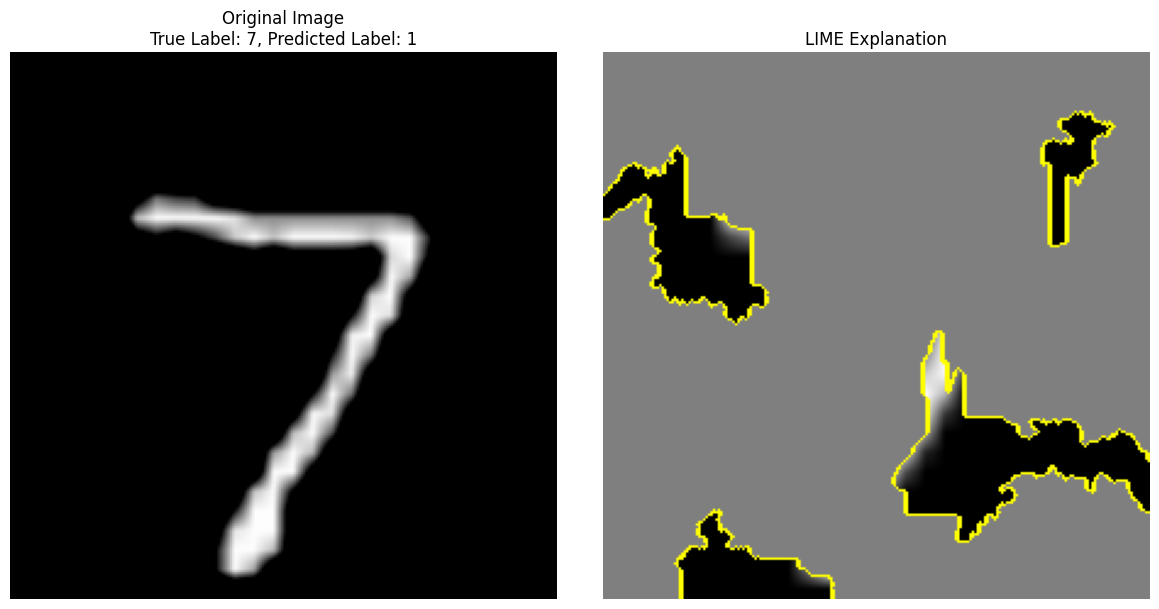

In [10]:
# Visualize the original image and the LIME explanation side by side
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(get_image(image[0]), cmap='gray')
plt.title(f"Original Image\nTrue Label: {label.item()}, Predicted Label: {pred_label}")
plt.axis('off')

# LIME Explanation
plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(img / 2 + 0.5, mask))
plt.title("LIME Explanation")
plt.axis('off')

plt.tight_layout()
plt.show()

In the visualization, there are two panels that help us understand what the model is doing:

**Left panel - "Original Image":** This shows a handwritten digit "7" where the actual label for the image is 7, but the model mistakenly predicted it as 1.

**Right panel - "LIME Explanation":** On this side, we see how LIME explains why the model made this mistake. The gray background and the yellow outline highlight which parts of the digit were most important to the model's prediction. The black areas inside the outline show the parts of the image that had the most influence on the model’s decision.

The LIME explanation helps us see why the model might have confused the "7" with a "1." It looks like the model may have focused a lot on the vertical line of the 7, which is very similar to the shape of a 1. The model didn't seem to care as much about the horizontal line at the top of the 7, which might have caused the misclassification. This visualization is useful because it gives us a better understanding of why the model made a mistake. It shows that the model needs more training to learn how to tell 7s and 1s apart, especially when the 7 has a strong vertical part. By looking at this, we can figure out where the model needs to improve.



---



## Discussion: Why I Chose LIME
For this assignment, I chose LIME (Local Interpretable Model-agnostic Explanations) as the explanation technique for the following reasons:

####**Strengths:**    

a. Model-agnostic: LIME works with any black-box model, making it versatile for explaining complex architectures like ResNet.
b. Local Explanations: It focuses on explaining individual predictions, providing detailed insights into how the model handles specific inputs.
c. Visual Intuition: It offers easy-to-understand visual explanations, especially for image classification tasks.

####**Limitations:**  

a. Computationally Expensive: Generating explanations using LIME can be slow, especially for large datasets or complex models.
b Hyperparameter Sensitivity: Results can vary depending on the choice of segmentation algorithm and the number of perturbation samples.

####**Potential Improvements:**  
a. Experiment with different segmentation algorithms to see if the explanations change.  
b. Test other explanation techniques like SHAP or Anchors to compare their performance on this task.  
c. Analyze a broader range of images from the test set to understand global model behavior better.
